Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (200, 5)
****************************************************************************************************

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
****************************************************************************************************
Number of Uniques:
 CustomerID                200
Gender                      2
Age                        51
Annual Incom

interactive(children=(Dropdown(description='col', options=('customer_id', 'gender', 'age', 'income', 'score'),…

Dropdown(description='Column:', options=('customer_id', 'gender', 'age', 'income', 'score'), value='customer_i…

Output()

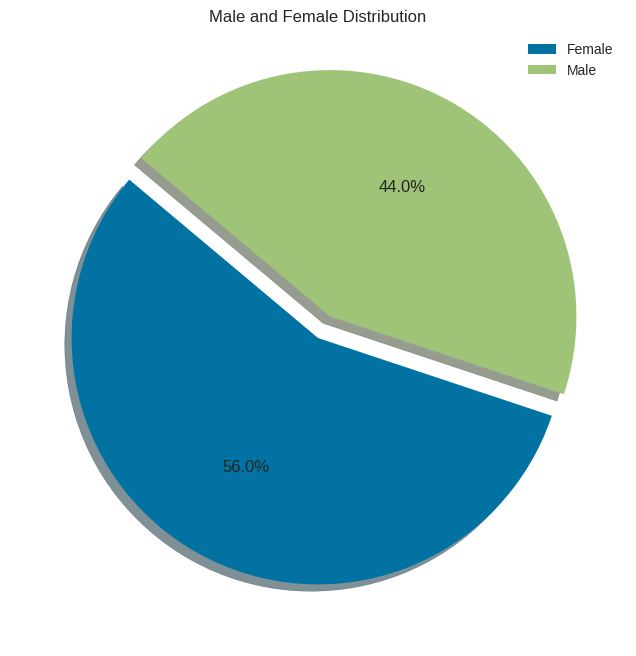

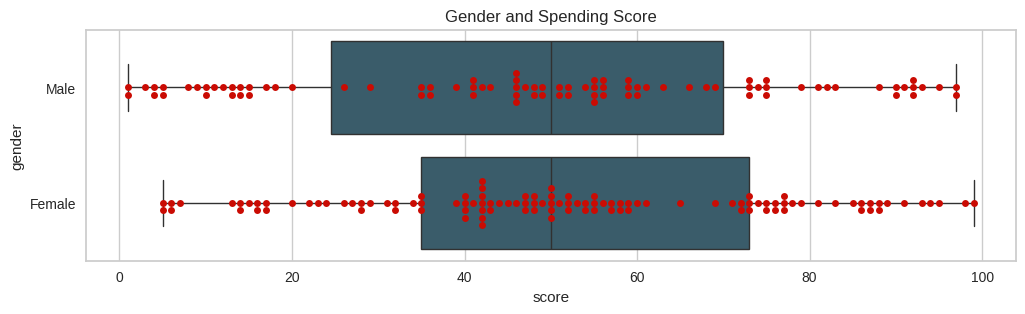

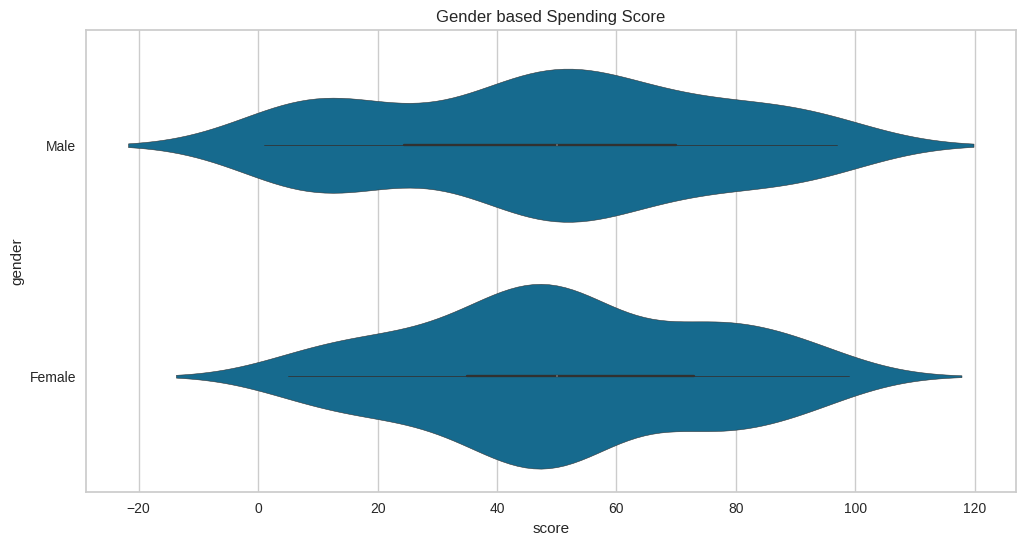

Mean Hopkins statistic (MinMaxScaler): 0.6936778562624041
Mean Hopkins statistic (StandardScaler): 0.6986162729786054
Silhouette Score: 0.4383860846531993


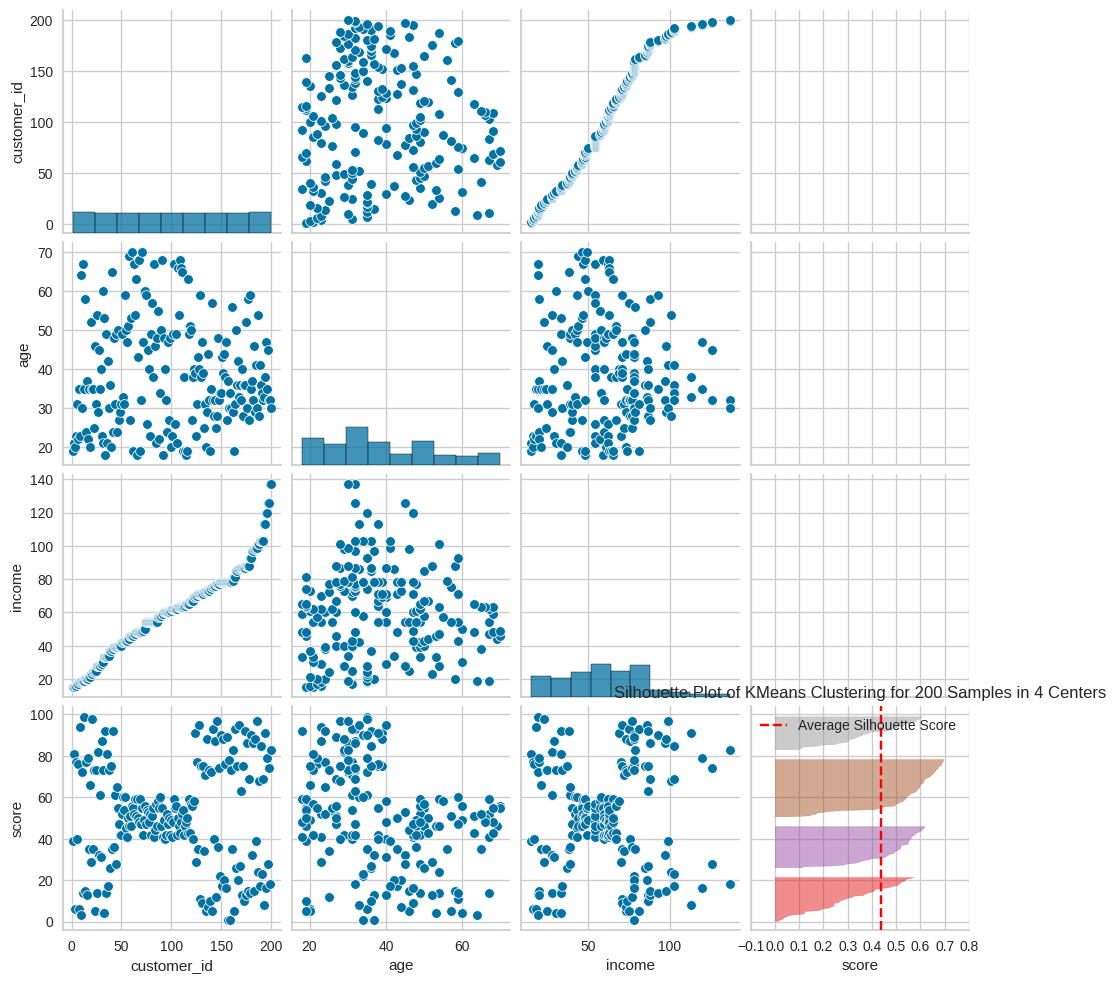

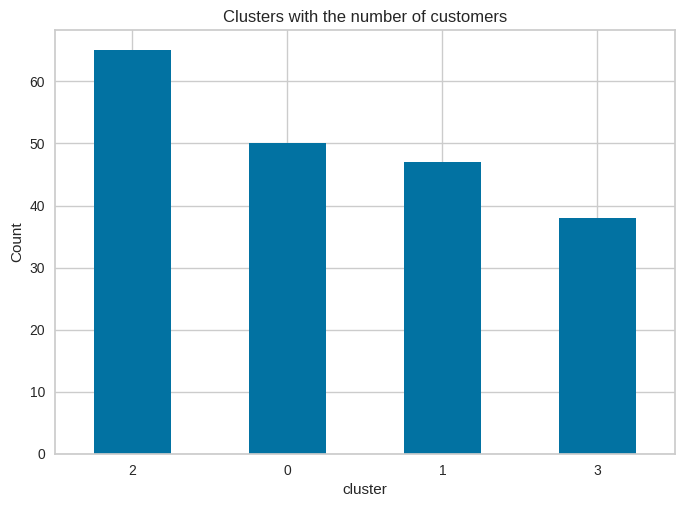

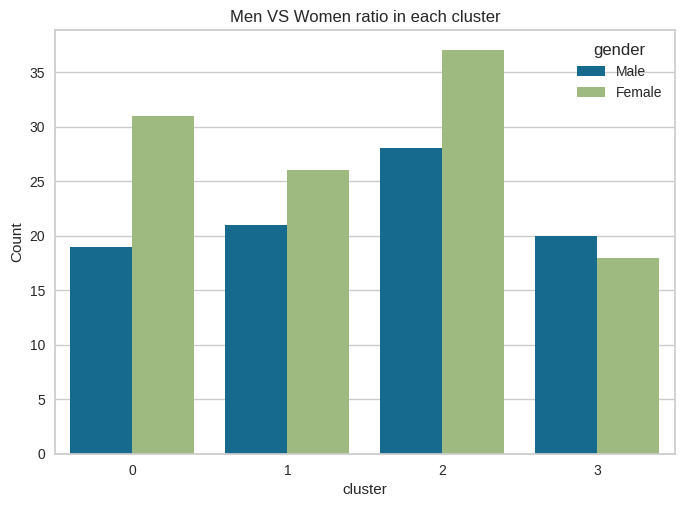

<Figure size 2000x600 with 0 Axes>

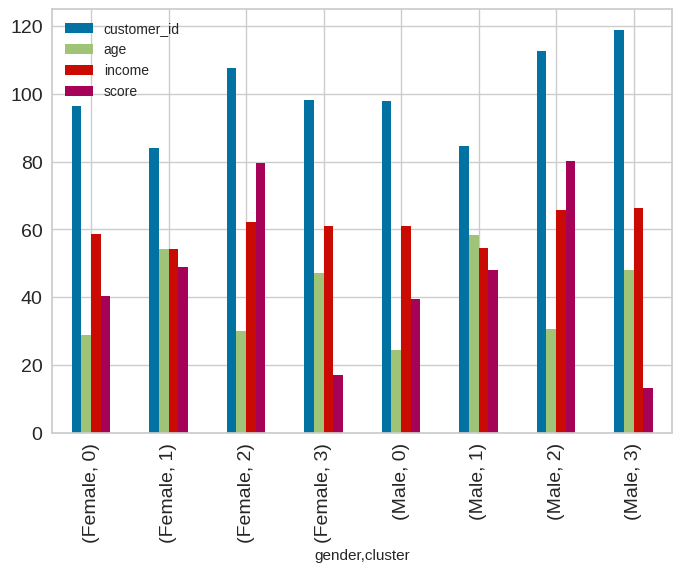

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from colorama import Fore, Style
from termcolor import colored
import warnings
from google.colab import drive
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from random import sample

warnings.filterwarnings('ignore')

# Function to display missing values
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number'] > 0]

# Function for initial data exploration
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape)
    print(colored('*' * 100, 'red', attrs=['bold']))
    print(colored("\nInfo:\n", attrs=['bold']))
    print(df.info())
    print(colored('*' * 100, 'red', attrs=['bold']))
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique())
    print(colored('*' * 100, 'red', attrs=['bold']))
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df))
    print(colored('*' * 100, 'red', attrs=['bold']))
    print(colored("All Columns:", attrs=['bold']), list(df.columns))
    print(colored('*' * 100, 'red', attrs=['bold']))
    print(colored("Descriptive Statistics \n", attrs=['bold']), df.describe().round(2))
    print(colored('*' * 100, 'red', attrs=['bold']))

# Function to remove duplicates
def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']))
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"), sep='')
    else:
        print(colored("There are no duplicates"), sep='')

# Mount Google Drive
drive.mount('/content/drive')

# Load data
file_path = "/content/drive/MyDrive/project/Mall_Customers.csv"
mall_customers_data_raw = pd.read_csv(file_path)
mall_customers_data = mall_customers_data_raw.copy()

# Initial data exploration
first_looking(mall_customers_data)
duplicate_values(mall_customers_data)
print("Last Shape: ", mall_customers_data.shape)

# Rename columns
mall_customers_data.rename(columns={"CustomerID":"customer_id", "Gender":"gender", "Age":"age", "Annual Income (k$)": "income",
                                    "Spending Score (1-100)":"score"}, inplace=True)

# Analyze numeric data
numeric_mall_customers_data = mall_customers_data.select_dtypes(include='number')
fig = px.imshow(numeric_mall_customers_data.corr(), height=1000, width=1000, range_color=[-1,1])
fig.show()

# Function to display histogram of a column
def column_histogram(col, show_kde=False):
    plt.figure(figsize=(10, 5))
    sns.histplot(mall_customers_data[col], kde=show_kde, bins=80)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Interact widget for histogram
cols = mall_customers_data.columns
interact(column_histogram, col=cols, show_kde=True)

# Function to display box plot of a column
def column_boxplot(col):
    fig = px.box(mall_customers_data, y=col)
    fig.show()

# Interact widget for box plot
dropdown = widgets.Dropdown(options=cols, description='Column:')
output = widgets.interactive_output(column_boxplot, {'col': dropdown})
display(dropdown, output)

# Analyze male customers
male_customers = mall_customers_data[mall_customers_data["gender"] == "Male"]
mean_male_customers = male_customers.select_dtypes(include='number').mean()
median_male_customers = male_customers.select_dtypes(include='number').median()

# Pie chart for male and female distribution
plt.figure(figsize=(8, 8))
explode = [0, 0.1]
plt.pie(mall_customers_data['gender'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['Female', 'Male'])
plt.title('Male and Female Distribution')
plt.axis('off')
plt.show()

# Gender and spending score visualization
plt.figure(figsize=(12, 3))
sns.swarmplot(x='score', y='gender', data=mall_customers_data, color="r")
sns.boxplot(x='score', y='gender', data=mall_customers_data, saturation=.3)
plt.title('Gender and Spending Score')
plt.show()

# Gender based spending score visualization
plt.figure(figsize=(12, 6))
sns.violinplot(x='score', y='gender', data=mall_customers_data)
plt.title('Gender based Spending Score')
plt.show()

# Pair plot for data
sns.pairplot(mall_customers_data)

# Function to compute Hopkins statistic
def hopkins(X, ratio=0.05):
    if not isinstance(X, np.ndarray):
        X = X.values  # Convert dataframe to a numpy array
    sample_size = int(X.shape[0] * ratio)

    # Uniform random sample in the original data space
    X_uniform_random_sample = np.random.uniform(X.min(axis=0), X.max(axis=0), (sample_size, X.shape[1]))

    # Random sample of size sample_size from the original data X
    random_indices = np.random.choice(X.shape[0], sample_size, replace=False)
    X_sample = X[random_indices]

    # Initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)

    # Distances from each observation to each cluster centroid
    u_distances, u_indices = nbrs.kneighbors(X_uniform_random_sample, n_neighbors=2)
    u_distances = u_distances[:, 0]  # Distance to the first (nearest) neighbour

    # Distances from observations in each cluster to their own centroid
    w_distances, w_indices = nbrs.kneighbors(X_sample, n_neighbors=2)
    w_distances = w_distances[:, 1]  # Distance to the second nearest neighbour (first neighbour is the point itself)

    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    # Compute and return Hopkins' statistic
    H = u_sum / (u_sum + w_sum)
    return H

# Compute Hopkins statistic for data
age_and_score_data_minmax = mall_customers_data[["age", "score"]].copy()
age_and_score_data_standard = mall_customers_data[["age", "score"]].copy()

result_minmax = []
result_standard = []

for _ in range(10):
    result_minmax.append(hopkins(MinMaxScaler().fit_transform(age_and_score_data_minmax), 1))
    result_standard.append(hopkins(StandardScaler().fit_transform(age_and_score_data_standard), 1))

print("Mean Hopkins statistic (MinMaxScaler):", np.mean(result_minmax))
print("Mean Hopkins statistic (StandardScaler):", np.mean(result_standard))

# Perform KMeans clustering
X = mall_customers_data[["age", "score"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Compute silhouette score
silhouette_avg = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", silhouette_avg)

# Visualize silhouette scores
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(X_scaled)
visualizer.poof();

# Analyze clusters
df_clusters = mall_customers_data.copy()
df_clusters["cluster"] = clusters

# Visualize clusters in 3D
fig = px.scatter_3d(df_clusters, x="score", y="income", z="age", color="cluster", hover_name="income")
fig.show()

# Plot cluster distribution
plt.title("Clusters with the number of customers")
plt.xlabel("Clusters")
plt.ylabel("Count")
df_clusters["cluster"].value_counts().plot(kind='bar', rot=0)
plt.show()

# Plot men vs women ratio in each cluster
plt.title("Men VS Women ratio in each cluster")
plt.ylabel("Count")
sns.countplot(x=df_clusters["cluster"], hue=df_clusters["gender"])
plt.show()

# Plot cluster means for each gender
plt.figure(figsize=(20, 6))
df_clusters.groupby(["gender", "cluster"]).mean().plot(kind="bar", fontsize=14)
plt.show()
